This notebook takes the experiment-wide identifications and their features (contained in percolator_df), calculates experiment-wide metrics for each sequence-charge, and run-specific metrics for each sequence-charge, and saves the merged dataframe to file-sequence-charge-attribs-df.pkl

In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os

In [2]:
import peakutils

In [3]:
NUMBER_OF_RUNS_IN_EXPERIMENT = 20

In [4]:
percolator_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/percolator_df.pkl')

In [5]:
percolator_df.columns

Index(['file_idx', 'scan', 'charge_x', 'spectrum precursor m/z',
       'spectrum neutral mass', 'peptide mass', 'percolator score',
       'percolator q-value', 'percolator PEP', 'total matches/spectrum',
       'sequence', 'protein id', 'flanking aa', 'feature_id', 'charge_y',
       'rt_apex', 'rt_peak_width', 'scan_apex', 'scan_peak_width', 'intensity',
       'precursor_id', 'monoisotopic_mass', 'predicted_mass_error',
       'recalibrated_monoisotopic_mass', 'recalibrated_monoisotopic_mz',
       'percolator_idx', 'batch', 'human'],
      dtype='object')

In [6]:
# remove the rubbish peptide masses
percolator_df = percolator_df[percolator_df['peptide mass'] > 0]

In [7]:
percolator_df[percolator_df.sequence == 'IFVGNVSAACTSQELR']

,file_idx,scan,charge_x,spectrum precursor m/z,spectrum neutral mass,peptide mass,percolator score,percolator q-value,percolator PEP,total matches/spectrum,...,scan_peak_width,intensity,precursor_id,monoisotopic_mass,predicted_mass_error,recalibrated_monoisotopic_mass,recalibrated_monoisotopic_mz,percolator_idx,batch,human
43388,11,7739,2,875.9370,1749.8594,1693.8457,0.965118,0.000003,2.873536e-09,3292.08,...,34.01,529549.0,33037,1750.866543,-0.000373,1750.866916,876.440734,11,1to1,True
46536,7,9891,2,875.9370,1749.8595,1693.8457,0.955662,0.000003,3.468265e-09,3292.08,...,34.98,485088.0,34815,1750.866497,-0.000329,1750.866825,876.440689,7,1to3,True
48107,16,11643,2,875.9370,1749.8594,1693.8457,0.951127,0.000003,3.795683e-09,3292.08,...,33.24,436011.0,35060,1750.865693,-0.001137,1750.866830,876.440691,16,1to3,True
63008,2,6659,2,875.9370,1749.8595,1693.8457,0.911468,0.000003,8.354538e-09,3292.08,...,33.79,596242.0,33047,1750.866809,-0.000506,1750.867315,876.440933,2,1to1,True
63527,11,5489,2,875.9372,1749.8599,1693.8457,0.910149,0.000003,8.576732e-09,3292.08,...,36.19,672013.0,33208,1750.867972,0.000438,1750.867533,876.441043,11,1to1,True
64403,1,7215,2,875.9371,1749.8597,1693.8457,0.907995,0.000003,8.952222e-09,3292.08,...,33.48,578544.0,33444,1750.866754,-0.000120,1750.866874,876.440713,1,1to1,True
66318,1,12446,2,875.9372,1749.8598,1693.8457,0.903688,0.000003,9.753059e-09,3292.08,...,33.05,384376.0,33371,1750.865822,-0.000728,1750.866550,876.440551,1,1to1,True
72465,12,9948,2,875.9371,1749.8596,1693.8457,0.889881,0.000003,1.283608e-08,3292.08,...,33.40,473755.0,33744,1750.866369,-0.000450,1750.866819,876.440686,12,1to1,True
84925,15,6077,2,875.9374,1749.8603,1693.8457,0.864476,0.000003,2.127726e-08,3292.08,...,32.51,637658.0,33090,1750.868631,0.001214,1750.867417,876.440984,15,1to1,True
87320,10,5592,2,875.9374,1749.8602,1693.8457,0.859721,0.000003,2.338818e-08,3292.08,...,32.66,705613.0,33622,1750.866963,-0.000443,1750.867406,876.440979,10,1to1,True


In [8]:
ADD_C_CYSTEINE_DA = 57.021464  # from Unimod.org
PROTON_MASS = 1.007276

In [9]:
def calculate_mono_mz(peptide_mass, charge):
    mono_mz = (peptide_mass + (PROTON_MASS * charge)) / charge
    return mono_mz

#### collate the experiment-wide metrics for each sequence-charge

In [10]:
# find the experiment-average for each sequence-charge identified
experiment_sequences_l = []
for group_name,group_df in percolator_df.groupby(['sequence','charge_x'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    peptide_mass = group_df.iloc[0]['peptide mass']
    peptide_mass_modification = peptide_mass + (sequence.count('C') * ADD_C_CYSTEINE_DA)
    theoretical_mz = calculate_mono_mz(peptide_mass=peptide_mass_modification, charge=charge)  # where the mono m/z should be, from the theoretical peptide mass
    experiment_scan = peakutils.centroid(group_df.scan_apex, group_df.intensity)
    experiment_scan_peak_width = group_df.scan_peak_width.mean()
    experiment_rt = peakutils.centroid(group_df.rt_apex, group_df.intensity)
    experiment_rt_peak_width = group_df.rt_peak_width.mean()
    experiment_intensity = group_df.intensity.mean()
    experiment_sequences_l.append((sequence, charge, theoretical_mz, experiment_scan, experiment_scan_peak_width, experiment_rt, experiment_rt_peak_width, experiment_intensity))
    

In [11]:
experiment_sequences_df = pd.DataFrame(experiment_sequences_l, columns=['sequence','charge','theoretical_mz', 'experiment_scan', 'experiment_scan_peak_width', 'experiment_rt', 'experiment_rt_peak_width', 'experiment_intensity'])


In [12]:
experiment_sequences_df.head()

,sequence,charge,theoretical_mz,experiment_scan,experiment_scan_peak_width,experiment_rt,experiment_rt_peak_width,experiment_intensity
0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.608726,73.911301,57.626667,602.012681,18.706667,108754.444444
1,AAAAAAAAAPAAAATAPTTAATTAATAAQ,3,790.074909,335.868469,56.366667,609.864140,5.030000,29377.333333
2,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.532126,160.291329,64.555556,489.973155,6.357111,58456.622222
3,AAAAALSQQQSLQER,2,786.410426,496.361511,45.912500,375.039574,6.140000,57092.250000
4,AAAAATVVPPMVGGPPFVGPVGFGPGDR,3,864.452776,707.537580,48.382593,1039.861047,16.666296,50988.518519


In [13]:
experiment_sequences_df[(experiment_sequences_df.sequence == 'IFVGNVSAACTSQELR') & (experiment_sequences_df.charge == 2)]

,sequence,charge,theoretical_mz,experiment_scan,experiment_scan_peak_width,experiment_rt,experiment_rt_peak_width,experiment_intensity
12970,IFVGNVSAACTSQELR,2,876.440858,367.805872,35.4034,623.104429,7.3356,472141.48


In [14]:
experiment_sequences_df.to_pickle('/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/training-sets/experiment-sequence-charge-attribs-df.pkl')

#### collate the run-specific metrics for each sequence-charge

In [15]:
percolator_df[(percolator_df.file_idx == 0) & (percolator_df.sequence == 'IFVGNVSAACTSQELR') & (percolator_df.charge_x == 2)]

,file_idx,scan,charge_x,spectrum precursor m/z,spectrum neutral mass,peptide mass,percolator score,percolator q-value,percolator PEP,total matches/spectrum,...,scan_peak_width,intensity,precursor_id,monoisotopic_mass,predicted_mass_error,recalibrated_monoisotopic_mass,recalibrated_monoisotopic_mz,percolator_idx,batch,human
106966,0,11879,2,875.9369,1749.8592,1693.8457,0.824662,0.000003,4.697788e-08,3292.08,...,34.06,414369.0,33823,1750.864954,-0.001605,1750.866558,876.440555,0,1to3,True
159872,0,11080,2,875.9374,1749.8601,1693.8457,0.746377,0.000003,2.229633e-07,3292.08,...,35.11,436546.0,33835,1750.866493,-0.000917,1750.867410,876.440981,0,1to3,True
223557,0,19728,2,875.9371,1749.8596,1693.8457,0.666176,0.000003,1.099280e-06,3292.08,...,30.26,286546.0,33705,1750.863510,-0.003539,1750.867049,876.440801,0,1to3,True


In [16]:
# for each run, find the mz, scan, RT, and intensity for each sequence-charge identified
run_sequences_l = []
for group_name,group_df in percolator_df.groupby(['file_idx','sequence','charge_x'], as_index=False):
    file_idx = group_name[0]
    sequence = group_name[1]
    charge = group_name[2]
    run_mz = peakutils.centroid(group_df.recalibrated_monoisotopic_mz, group_df.intensity)
    run_mz_std_dev = np.std(group_df.recalibrated_monoisotopic_mz)
    run_scan = peakutils.centroid(group_df.scan_apex, group_df.intensity)
    run_scan_std_dev = np.std(group_df.scan_apex)
    run_rt = peakutils.centroid(group_df.rt_apex, group_df.intensity)
    run_rt_std_dev = np.std(group_df.rt_apex)
    run_intensity = np.mean(group_df.intensity)
    run_intensity_std_dev = np.std(group_df.intensity)
    run_sequences_l.append((file_idx,sequence,charge,run_mz,run_scan,run_rt,run_mz_std_dev,run_scan_std_dev,run_rt_std_dev,run_intensity,run_intensity_std_dev))

In [17]:
run_sequences_df = pd.DataFrame(run_sequences_l, columns=['file_idx','sequence','charge','run_mz','run_scan','run_rt','run_mz_std_dev','run_scan_std_dev','run_rt_std_dev','run_intensity','run_intensity_std_dev'])


In [18]:
run_sequences_df.head()

,file_idx,sequence,charge,run_mz,run_scan,run_rt,run_mz_std_dev,run_scan_std_dev,run_rt_std_dev,run_intensity,run_intensity_std_dev
0,0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.608297,74.065131,601.582008,0.000006,0.465000,0.065000,146908.000000,15838.0000
1,0,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.532238,156.625361,486.692475,0.000094,2.523085,0.028284,53127.666667,4860.1922
2,0,AAAAAWEEPSSGNGTAR,2,823.382023,535.310000,367.240000,0.000000,0.000000,0.000000,258410.000000,0.0000
3,0,AAAAPVTGPLADDPIQETITFDDFAK,3,892.112877,468.100000,997.180000,0.000000,0.000000,0.000000,203979.000000,0.0000
4,0,AAAEDVNVTFEDQQK,2,832.891870,485.630000,471.790000,0.000000,0.000000,0.000000,74963.000000,0.0000


In [19]:
import matplotlib.pyplot as plt

In [20]:
run_sequences_df['cv_mz'] = run_sequences_df.run_mz_std_dev / run_sequences_df.run_mz
run_sequences_df['cv_scan'] = run_sequences_df.run_scan_std_dev / run_sequences_df.run_scan
run_sequences_df['cv_rt'] = run_sequences_df.run_rt_std_dev / run_sequences_df.run_rt
run_sequences_df['cv_intensity'] = run_sequences_df.run_intensity_std_dev / run_sequences_df.run_intensity

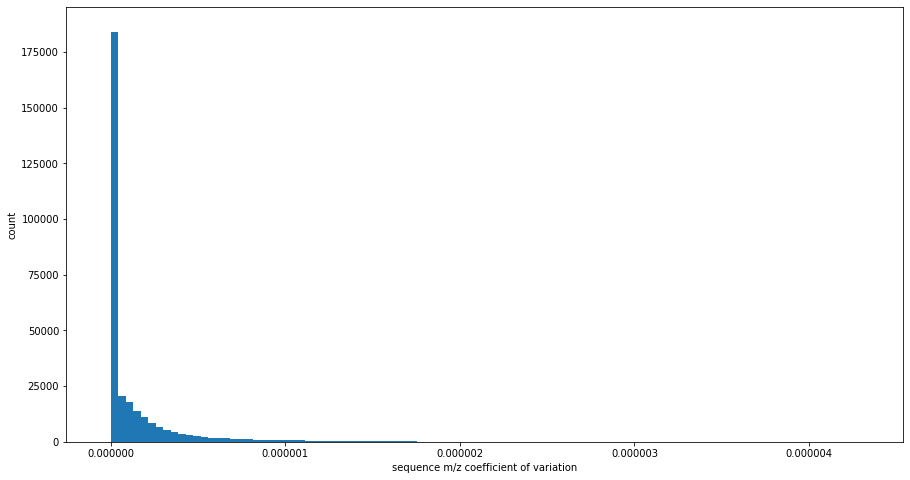

In [21]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(run_sequences_df.cv_mz, bins=bins)
plt.xlabel('sequence m/z coefficient of variation')
plt.ylabel('count')

plt.show()

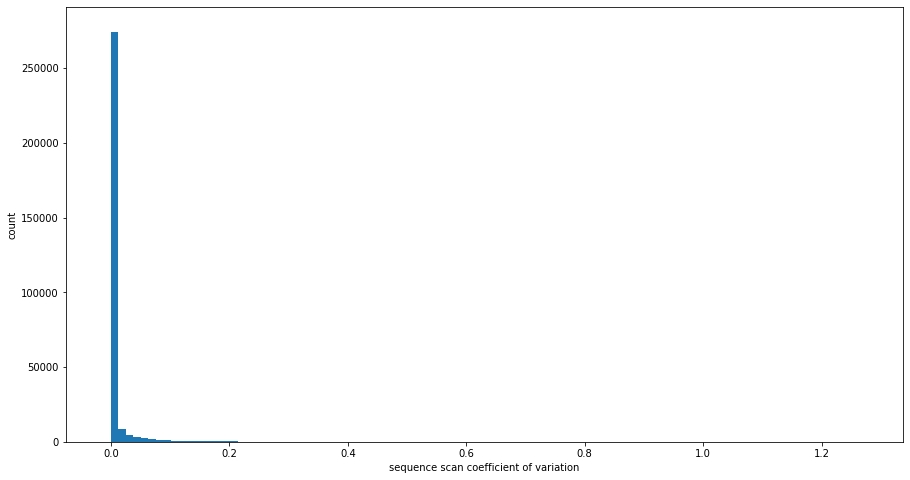

In [22]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(run_sequences_df.cv_scan, bins=bins)
plt.xlabel('sequence scan coefficient of variation')
plt.ylabel('count')

plt.show()

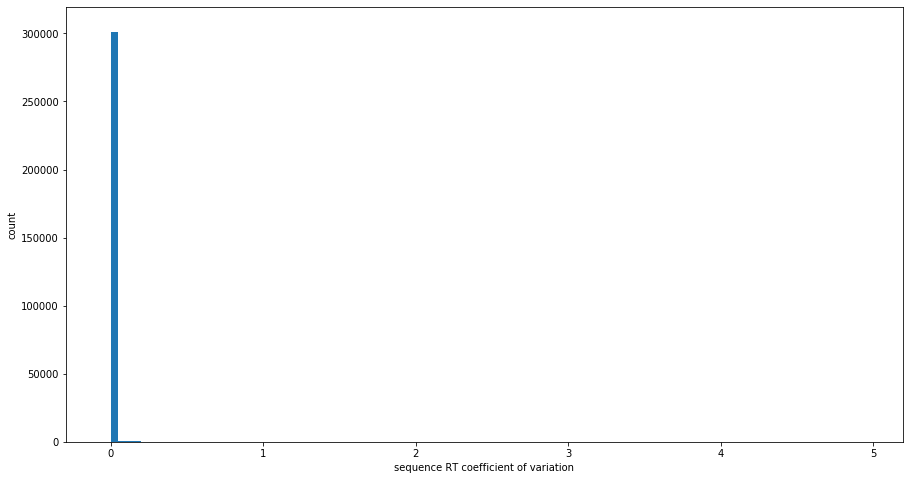

In [23]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(run_sequences_df.cv_rt, bins=bins, label='m/z delta')
plt.xlabel('sequence RT coefficient of variation')
plt.ylabel('count')

plt.show()

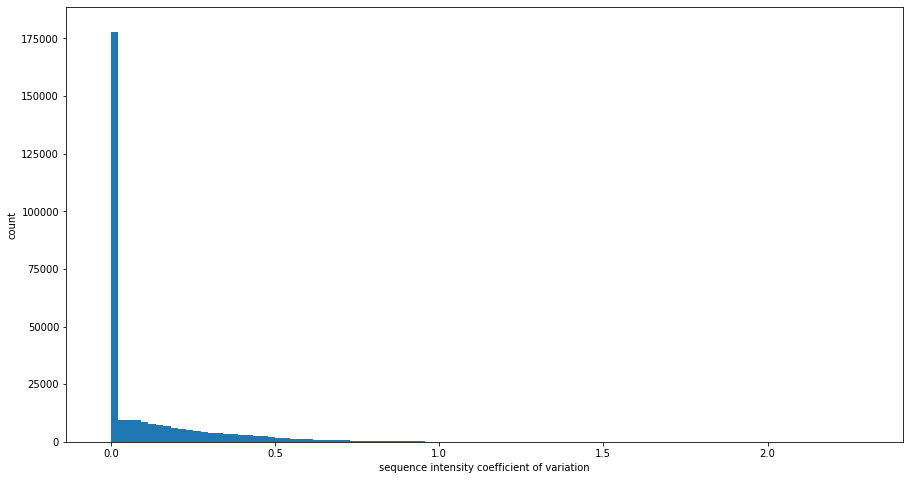

In [24]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(run_sequences_df.cv_intensity, bins=bins)
plt.xlabel('sequence intensity coefficient of variation')
plt.ylabel('count')

plt.show()

In [25]:
# merge the sequence-charges for each run with their experiment-wide averages
merged_df = pd.merge(run_sequences_df, experiment_sequences_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])

In [26]:
# for each run-sequence-charge, calculate the delta from the experiment-wide average
merged_df['delta_mz'] = merged_df.run_mz - merged_df.theoretical_mz
merged_df['delta_mz_ppm'] = (merged_df.run_mz - merged_df.theoretical_mz) / merged_df.theoretical_mz * 1e6
merged_df['delta_scan'] = (merged_df.run_scan - merged_df.experiment_scan) / merged_df.experiment_scan
merged_df['delta_rt'] = (merged_df.run_rt - merged_df.experiment_rt) / merged_df.experiment_rt

In [27]:
merged_df.head()

,file_idx,sequence,charge,run_mz,run_scan,run_rt,run_mz_std_dev,run_scan_std_dev,run_rt_std_dev,run_intensity,...,theoretical_mz,experiment_scan,experiment_scan_peak_width,experiment_rt,experiment_rt_peak_width,experiment_intensity,delta_mz,delta_mz_ppm,delta_scan,delta_rt
0,0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.608297,74.065131,601.582008,0.000006,0.465000,0.065000,146908.000000,...,1184.608726,73.911301,57.626667,602.012681,18.706667,108754.444444,-0.000429,-0.362138,0.002081,-0.000715
1,0,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.532238,156.625361,486.692475,0.000094,2.523085,0.028284,53127.666667,...,1016.532126,160.291329,64.555556,489.973155,6.357111,58456.622222,0.000112,0.110661,-0.022871,-0.006696
2,0,AAAAAWEEPSSGNGTAR,2,823.382023,535.310000,367.240000,0.000000,0.000000,0.000000,258410.000000,...,823.381876,533.861853,53.898095,371.271659,6.114524,277023.690476,0.000147,0.178836,0.002713,-0.010859
3,0,AAAAPVTGPLADDPIQETITFDDFAK,3,892.112877,468.100000,997.180000,0.000000,0.000000,0.000000,203979.000000,...,892.113043,465.668232,115.010000,997.391366,6.381000,150202.950000,-0.000166,-0.185660,0.005222,-0.000212
4,0,AAAEDVNVTFEDQQK,2,832.891870,485.630000,471.790000,0.000000,0.000000,0.000000,74963.000000,...,832.891726,487.082550,43.335455,475.841292,8.563636,116982.693430,0.000144,0.172336,-0.002982,-0.008514


In [28]:
merged_df.drop(['run_mz_std_dev','run_scan_std_dev','run_rt_std_dev','run_intensity_std_dev'], axis=1, inplace=True)

In [29]:
merged_df.to_pickle('/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/training-sets/file-sequence-charge-attribs-df.pkl')

In [30]:
merged_df[(merged_df.sequence == 'IFVGNVSAACTSQELR') & (merged_df.charge == 2)]

,file_idx,sequence,charge,run_mz,run_scan,run_rt,run_intensity,cv_mz,cv_scan,cv_rt,...,theoretical_mz,experiment_scan,experiment_scan_peak_width,experiment_rt,experiment_rt_peak_width,experiment_intensity,delta_mz,delta_mz_ppm,delta_scan,delta_rt
5814,0,IFVGNVSAACTSQELR,2,876.440780,369.326725,619.319805,379153.666667,1.991248e-07,0.000678,0.000013,...,876.440858,367.805872,35.4034,623.104429,7.3356,472141.48,-0.000078,-0.088482,0.004135,-0.006074
20601,1,IFVGNVSAACTSQELR,2,876.440761,366.234008,625.130617,478617.000000,2.071031e-07,0.003853,0.000013,...,876.440858,367.805872,35.4034,623.104429,7.3356,472141.48,-0.000097,-0.110562,-0.004274,0.003252
36814,2,IFVGNVSAACTSQELR,2,876.440845,368.142272,625.011819,504485.000000,1.228483e-07,0.000041,0.000016,...,876.440858,367.805872,35.4034,623.104429,7.3356,472141.48,-0.000013,-0.014524,0.000915,0.003061
52145,3,IFVGNVSAACTSQELR,2,876.440738,363.063728,618.750000,377730.000000,2.090100e-07,0.000412,0.000000,...,876.440858,367.805872,35.4034,623.104429,7.3356,472141.48,-0.000120,-0.136360,-0.012893,-0.006988
66053,4,IFVGNVSAACTSQELR,2,876.440709,371.140000,617.950000,304269.000000,0.000000e+00,0.000000,0.000000,...,876.440858,367.805872,35.4034,623.104429,7.3356,472141.48,-0.000149,-0.169984,0.009065,-0.008272
79916,5,IFVGNVSAACTSQELR,2,876.440860,370.596378,619.317802,370322.000000,3.949696e-07,0.000324,0.000016,...,876.440858,367.805872,35.4034,623.104429,7.3356,472141.48,0.000002,0.002395,0.007587,-0.006077
93785,6,IFVGNVSAACTSQELR,2,876.440812,369.650000,618.790000,232492.000000,0.000000e+00,0.000000,0.000000,...,876.440858,367.805872,35.4034,623.104429,7.3356,472141.48,-0.000046,-0.052377,0.005014,-0.006924
107798,7,IFVGNVSAACTSQELR,2,876.440947,365.767369,620.395564,413068.250000,2.625924e-07,0.000263,0.000008,...,876.440858,367.805872,35.4034,623.104429,7.3356,472141.48,0.000089,0.101053,-0.005542,-0.004347
121837,8,IFVGNVSAACTSQELR,2,876.441046,370.532211,619.235827,278432.000000,2.456520e-07,0.002321,0.000008,...,876.440858,367.805872,35.4034,623.104429,7.3356,472141.48,0.000188,0.214653,0.007412,-0.006209
135782,9,IFVGNVSAACTSQELR,2,876.440824,364.066672,619.178086,369996.666667,1.698947e-07,0.001650,0.000008,...,876.440858,367.805872,35.4034,623.104429,7.3356,472141.48,-0.000034,-0.038664,-0.010166,-0.006301
